In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from helper_functions import *

In [4]:
import pandas as pd
from tqdm.notebook import tqdm
import re
from typing import List
import os
import matplotlib.pyplot as plt
import numpy as np
import artm
from collections import defaultdict

In [5]:
%%time
df = pd.read_excel('../data/avtoreferati.xlsx', sheet_name='Итог', header=0)

CPU times: user 6.64 s, sys: 136 ms, total: 6.78 s
Wall time: 6.78 s


In [6]:
df['Пункты паспорта специальности (области исследования) 1-ой специальности'].head(3)

0      2.5
1        3
2    3,4,5
Name: Пункты паспорта специальности (области исследования) 1-ой специальности, dtype: object

In [7]:
tasks_aux = {k: f't{k}' for k in range(1, 14)}
# 1: 't1', 2: 't2', 3: 't3', 4: 't4', 5: 't5', 6: 't6', 7: 't7', 8: 't8', 9: 't9', 10: 't10', 11: 't11', 12: 't12', 13: 't13'
res_aux = {f'{k}.1' : f'r{k}' for k in range(1, 14)}

res_aux.update({k: f'r{k}' for k in range(14, 21)})

In [8]:
df.rename(
    columns={'Годзащиты': 'year', 'Unnamed: 29': 'title', 
             'Пункты паспорта специальности (области исследования) 1-ой специальности': 'code',
            **tasks_aux,
            **res_aux,}, 
    inplace=True
)

In [9]:
df = df[['year', 'code', *list(res_aux.values())]]

### Работа с колонкой `code`

In [10]:
df.shape

(5798, 22)

In [11]:
def preprocess_code_column(values: list) -> pd.Series:
    res = []
    comp = re.compile(r'[.,]')
    chars = re.compile(r'[^0-9.,]')
    str2int = lambda lst: list(map(int, lst))
    for i, val_ in enumerate(values):
        val = str(val_)
        val = re.sub(chars, '', val)
        codes = comp.split(val)
        codes = str2int(codes)
        res.append(codes)
    return res

In [12]:
df['code'] = df.code.replace('?', np.nan)

In [13]:
df = df.dropna()
df.shape

(1254, 22)

In [14]:
code = df.code.astype('str').tolist()
assert len(code) == df.shape[0]

In [15]:
df['year'] = df.year.astype(int)

In [16]:
df['code'] = preprocess_code_column(code)

### рассматриваем только результаты (без задач)

In [17]:
df['text'] = df.apply(lambda row: 
                        row['r1'] + '. ' + row['r2'] + '. ' + row['r3'] + '. ' + \
                        row['r4'] + '. ' + row['r5'] + '. ' + row['r6'] + '. ' + \
                        row['r7'] + '. ' + row['r8'] + '. ' + row['r9'] + '. ' + \
                        row['r10'] + '. ' + row['r11'] + '. ' + row['r12'] + '. ' + \
                        row['r13'] + '. ' + row['r14'] + '. ' + row['r15'] + '. ' + \
                        row['r16'] + '. ' + row['r17'] + '. ' + row['r18'] + '. ' + \
                        row['r19'] + '. ' + row['r20'],
                        axis=1)

### Preprocessing

In [18]:
import pymorphy2
import os
from typing import List
import razdel

import nltk
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('russian')

cyrillic = re.compile(r'[^а-я ]')
mult_ws = re.compile(r'\s+')
fix_punct = re.compile(r'\s+(\?|\.|,|!|:)')

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /home/robez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/robez/ds_venv2/lib/python3.8/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [19]:
def process_regex(re_words_to_remove,
                  re_mult_ws,
                  text: str) -> str:
    '''
    строковый предпроцессинг предложения
    '''
    text = text.lower()
    text = re.sub(re_words_to_remove, ' ', text)
    text = re.sub(re_mult_ws, ' ', text)
    text = text.strip()
    return text

def lemmatize(text: str, lemmatizer, min_word_size: int = 5) -> List[str]:
    words = [token.text for token in razdel.tokenize(text)]
    res = []
    for word in words:
        if word not in stopwords:# and len(word) > 1:
            p = lemmatizer.parse(word)[0]
            word_normal_form = p.normal_form
            if len(word_normal_form) < min_word_size:
                continue
            res.append(word_normal_form.replace('ё', 'е'))
    return res

def process_doc(doc: List[str], lemmatizer, min_word_size=3, min_sent_size=10) -> List[str]:
    proc_doc = []
    if not isinstance(doc, list):
        doc = [doc]
    for sent in doc:
        proc_sent = process_regex(
            cyrillic,
            mult_ws,
            text=sent
        )
        proc_sent_tokens = lemmatize(proc_sent, lemmatizer, min_word_size)
        # порог по длине предложения
        if len(proc_sent_tokens) < min_sent_size:
            continue
        proc_sent = ' '.join(proc_sent_tokens)
        proc_doc.append(proc_sent)
    return proc_doc

def sentenize_doc(doc: str) -> List[str]:
    return [sent.text for sent in razdel.sentenize(doc) if sent.text]

In [20]:
df['text_sent'] = df.text.apply(lambda row: sentenize_doc(row))

In [21]:
%%time
df['text_sent_proc'] = df.text_sent.apply(
    lambda row: process_doc(
                            row,
                            lemmatizer=morph,
                            min_word_size=2,
                            min_sent_size=5
    )
)

CPU times: user 1min 23s, sys: 299 ms, total: 1min 23s
Wall time: 1min 23s


In [22]:
%%time
df['text_clean'] = df.text_sent_proc.apply(lambda row:
                                           ' '.join(row)
                                          )

CPU times: user 12.1 ms, sys: 2 µs, total: 12.1 ms
Wall time: 11.9 ms


In [23]:
# проверяем пустые тексты после обработкиы
df.text_clean = df.text_clean.replace('', np.nan)
df.text_clean[df.text_clean.isna()]

528    NaN
Name: text_clean, dtype: object

In [24]:
df.dropna(inplace=True)

In [25]:
texts = df.text_clean.tolist()
years = df.year.tolist()

In [26]:
# сохраняем тексты
with open('texts.txt', 'w') as fh:
    fh.writelines([f'{text}\n' for text in texts])

In [27]:
with open('texts.txt') as fh:
    texts = fh.readlines()

In [28]:
def convert_texts_to_tokens(texts):
    return [text.split() for text in texts]

In [29]:
tokens = convert_texts_to_tokens(texts)

In [30]:
vocab_source = set()
for row in tokens:
    for token in row:
        if token not in vocab_source:
            vocab_source.add(token)

print(f'Размер исходного словаря = {len(vocab_source)}')

Размер исходного словаря = 14959


### Применение TF-IDF для исключения часто встречающихся терминов

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 1),
                        lowercase=True,
                        max_df=0.2,
                        analyzer='word')

In [32]:
tfidf_matrix = tfidf.fit_transform(texts)

In [33]:
features = tfidf.get_feature_names()

In [34]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns = features)

In [35]:
df_tfidf_sum = df_tfidf.sum(axis=0)
res = pd.DataFrame({'Vocab': df_tfidf_sum.index, 'Frequency': df_tfidf_sum.values})\
    .sort_values(by='Frequency', ascending=False)

In [36]:
res[res.Vocab == 'зуб'] # видим, что "зуб" будет отфильтрован

,Vocab,Frequency


In [37]:
TFIDF_SUM_THRESH = 10.0

### Словарь после фильтрации по $\sum$ TFIDF

In [38]:
vocab_filtered = res.Vocab[res.Frequency < TFIDF_SUM_THRESH].values.tolist()

#### Удаленный словарь

In [39]:
# res.Vocab[res.Frequency >= TFIDF_SUM_THRESH].values.tolist()

#### Размер словаря до и после применения TF-IDF

In [40]:
len(vocab_source), len(vocab_filtered)

(14959, 14810)

### Фильтрация текста по новому словарю

In [41]:
texts_filtered = []
for i, row in tqdm(enumerate(tokens)):
    cur_text_tokens = []
    for token in row:
        if token in vocab_filtered:
            cur_text_tokens.append(token)
    if cur_text_tokens:
        cur_text = ' '.join(cur_text_tokens)
        texts_filtered.append(cur_text)
    else:
        print(i)
        print(row)

0it [00:00, ?it/s]

### Количество авторефератов по годам

''

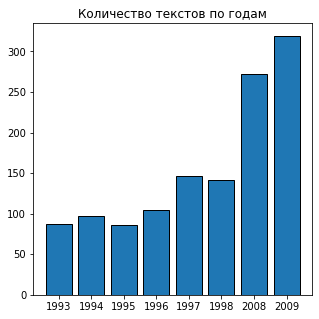

In [42]:
timeline = defaultdict(list)
for year, text in zip(years, texts_filtered):
    timeline[year].append(text) 

timeline_count = {}
for year in timeline:
    timeline_count[year] = len(timeline[year])
#     print(f'{year}: {len(timeline[year]):<10}')

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(range(len(timeline_count)), timeline_count.values(), edgecolor='k')
ax.set_xticks(
    ticks=np.arange(0, len(list(timeline_count.keys()))),
    labels=list(timeline_count.keys())
)
ax.set_title('Количество текстов по годам')
;

функция снизу для инференса [SO](https://stackoverflow.com/questions/34449127/sklearn-tfidf-transformer-how-to-get-tf-idf-values-of-given-words-in-documen#:~:text=3-,Finding,-tfidf%20score%20per)

In [43]:
# def get_ifidf_for_words(text):
#     tfidf_matrix= tfidf.transform([text]).todense()
#     feature_index = tfidf_matrix[0,:].nonzero()[1]
#     tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[0, x] for x in feature_index])
#     return dict(tfidf_scores)

# Тематическое моделирование

In [44]:
!rm -rf batches
!rm -f cv_wabbit*.vw vocab.txt

In [45]:
@check_path
def vocabulary_prep(text, vocab):
     with open(vocab, 'w') as fh:
        for sent in text:
            fh.write(' |text ' + sent + '\n')

In [46]:
## для всех текстов сразу
# cv_vocab_path = 'cv_wabbit_v2.vw'
# vocabulary_prep(texts_filtered, cv_vocab_path)

In [47]:
## динамика по годам
for year in timeline:
    vocabulary_prep(timeline[year], f'cv_wabbit_{year}.vw')

#### Подготовка бачтей

In [48]:
batch_vectorizers = {}
dictionaries = {}
for year in timeline:
    batch_vectorizers[year] = batching(data_path=f'cv_wabbit_{year}.vw',
                                      batch_path=f'batches/{year}')
    
    dictionary = artm.Dictionary()
    dictionary.gather(batch_vectorizers[year].data_path)
    
    dictionaries[year] = dictionary

In [49]:
# batch_vectorizer = batching(data_path=cv_vocab_path)

### Create an ARTM dictionary

In [50]:
# dictionary = artm.Dictionary()
# dictionary.gather(batch_vectorizer.data_path)

### Save / load dictionary

In [51]:
## !rm -f vocab.txt
# dictionary.save_text('vocab.txt')
# dictionary.load_text(dictionary_path='vocab.txt')

### ARTM model initialization

[пример](https://www.coursera.org/learn/unsupervised-learning/supplement/suSWG/noutbuk-iz-diemonstratsii-ispol-zovaniia-bigartm)

In [52]:
T = 5  # число тем
num_collection_passes = 10  # число проходов по коллекции

In [53]:
def init_model_artm(dictionary):
    model_artm = artm.ARTM(num_topics=T,
                           topic_names=[str(i + 1) for i in range(T)],
                           class_ids={"text":1},
                           reuse_theta=True, 
                           cache_theta=True,
                           num_document_passes=3,
                           seed=0)
    
    # add scorers
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id='text'))
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model_artm.scores.add(artm.TopTokensScore(name='top_words', num_tokens=T, class_id='text'))
    
    model_artm.initialize(dictionary=dictionary)
    return model_artm

# model_artm = init_model_artm(dictionary)

`phi score`: разреженность матрицы распределения терминов в теме

`theta score`: разреженность матрицы распределения тем в документах


$\Phi$: `model_artm.get_phi()`
по столбцам стоят отдельные темы, по строкам - слова в коллекции, значение = P(w|t)

$\Theta$: `model_artm.get_theta()`
по столбцам - документы, по строкам - темы, значение = P(t|d)


### 0. Модель без регуляризаторов

In [54]:
for year in tqdm(timeline):
    model_artm = init_model_artm(dictionaries[year])
    model_artm.fit_offline(batch_vectorizer=batch_vectorizers[year],
                           num_collection_passes=num_collection_passes)
    
    print(f'{year:^60}\n')
    tokens_printer(model_artm)
    
    print(f'\n{"#"*60}\n')

  0%|          | 0/8 [00:00<?, ?it/s]

                            1993                            

1: железа, передний, отросток, сиаладенит, язык

2: животное, титан, удаление, свойство, профилактический

3: фтор, корень, кислота, твердый, кариозный

4: размер, лпу, резистентность, гнойный, схп

5: раствор, оттиск, вт, минута, орбитальный


############################################################

                            1994                            

1: прикус, предложить, положение, вмешательство, нагрузка

2: физический, работоспособность, диабет, сахарный, опухоль

3: дуга, яремный, постоянный, размер, исходный

4: эпулис, профилактика, паста, болезнь, минеральный

5: ширина, отдел, височный, дистальный, губа


############################################################

                            1995                            

1: сужение, постоянный, клетка, кпу, летний

2: железа, слюнный, околоушный, паротит, болезнь

3: женщина, летний, профилактический, кхс, масса

4: лазерный, свет, пятно, миофа

### Подсчет тем в документах

NB: пример дан для модели, построенной на текстах по последнему году, поэтому текстов всего 319

In [55]:
theta = model_artm.get_theta()
TOPIC_PROBA_THRESHOLD = 0.1

In [56]:
# сортировка колонок в таблице по возрастанию
# колонка = id документа в коллекции
theta = theta.reindex(sorted(theta.columns), axis=1)

In [57]:
theta.shape

(5, 319)

### Подсчет значений вероятностей для каждого документа

Документ $\rightarrow$ n тем

In [ ]:
# %%time

# doc_index_to_topics_dict = defaultdict(list)
# for col in theta:
#     above_thresh = theta[col][theta[col] > TOPIC_PROBA_THRESHOLD]
#     topic_names = above_thresh.index.tolist()
#     topic_probas = above_thresh.tolist()
    
#     for name, proba in zip(topic_names, topic_probas):
#         doc_index_to_topics_dict[col].append((name, proba))
        
        
# # doc_index_to_topics_dict[2]

In [58]:
sort_theta_bins = lambda bins: dict(sorted(list(bins.items()), key=lambda x: int(x[0])))

def count_topics_in_collection(df_theta, min_proba=TOPIC_PROBA_THRESHOLD):
    theta_bins = defaultdict(int)
    for col in df_theta:
        above_thresh = df_theta[col][df_theta[col] > min_proba]
        topic_names = above_thresh.index.tolist()
        for name in topic_names:
            theta_bins[name] += 1 

    theta_bins = sort_theta_bins(theta_bins)

    return theta_bins

In [59]:
theta_bins = count_topics_in_collection(theta, TOPIC_PROBA_THRESHOLD)

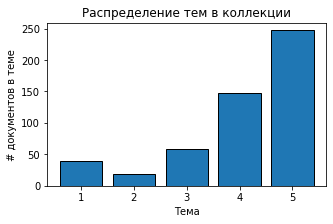

In [61]:
plot_collection_topic_distribution(theta_bins)

### Regularizers: 1

[Decorrelator Phi](https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html#decorrelator-phi)
* $\tau > 0 \rightarrow$ токены различаются сильные в разных темах
* $\tau < 0 \rightarrow$ токены в разных темах становятся более похожими друг на друга

In [68]:
for year in tqdm(timeline):
    model_artm = init_model_artm(dictionaries[year])
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrPhi', tau=+1e3))
    model_artm.fit_offline(batch_vectorizer=batch_vectorizers[year],
                           num_collection_passes=num_collection_passes)
    
    print(f'{year:^60}\n')
    tokens_printer(model_artm)
    
    print(f'\n{"#"*60}\n')

  0%|          | 0/8 [00:00<?, ?it/s]

                            1993                            

1: железа, передний, отросток, сиаладенит, язык

2: животное, титан, удаление, свойство, профилактический

3: фтор, корень, кислота, твердый, кислотный

4: размер, лпу, резистентность, гнойный, ск

5: раствор, оттиск, вт, орбитальный, минута


############################################################

                            1994                            

1: прикус, предложить, положение, вмешательство, нагрузка

2: физический, работоспособность, диабет, сахарный, опухоль

3: дуга, яремный, постоянный, размер, исходный

4: эпулис, профилактика, паста, болезнь, минеральный

5: ширина, отдел, височный, дистальный, губа


############################################################

                            1995                            

1: сужение, постоянный, клетка, кпу, летний

2: железа, слюнный, околоушный, паротит, болезнь

3: женщина, летний, профилактический, кхс, масса

4: лазерный, свет, пятно, миофас

In [69]:
# %%time
# model_artm = init_model_artm()
# model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrPhi', tau=+1e3))
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
#                       num_collection_passes=num_collection_passes)
# tokens_printer(model_artm)
# show_matrices_sparsity(model_artm)

In [70]:
# theta_0 = model_artm.get_theta()
# theta_bins_0 = count_topics_in_collection(theta_0, TOPIC_PROBA_THRESHOLD)
# plot_collection_topic_distribution(theta_bins_0)

### Regularizers: 2
[SmoothSparsePhiRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#decorrelator-phi)
* $\tau > 0 \rightarrow$ сглаживает матрицу $\Phi$
* $\tau < 0 \rightarrow$ разрежает матрицу $\Phi$

* можно задавать `tau` без `dictionary` - тогда регуляризация для каждого слова в словаре будет одинаковой (разумные значения -2.5, -5)
* если задан `tau (<0) & dictionary` - чем более вероятно слово во всей коллекции (чем большую частоту оно имеет), тем менее вероятно оно будет входить в отдельные темы
* для применения регуляризатора к отдельным модальностям
```python
class_ids=['text']
```

In [76]:
for year in tqdm(timeline):
    model_artm = init_model_artm(dictionaries[year])
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrPhi', tau=+1e3))
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e3,
                                                                dictionary=dictionary))
    model_artm.fit_offline(batch_vectorizer=batch_vectorizers[year],
                           num_collection_passes=num_collection_passes)
    
    print(f'{year:^60}\n')
    tokens_printer(model_artm)
    
    print(f'\n{"#"*60}\n')

  0%|          | 0/8 [00:00<?, ?it/s]

                            1993                            

1: железа, отросток, передний, это, время

2: титан, удаление, трансплантат, имплантация, свойство

3: корень, твердый, кариозный, травма, фтор

4: концентрация, гнойный, резистентность, возникновение, размер

5: раствор, оттиск, вт, минута, ран


############################################################

                            1994                            

1: прикус, нагрузка, положение, мка, воспаление

3: постоянный, дуга, коронка, мышечный, исходный

4: влияние, профилактика, взрослый, наблюдаться, основный

5: обеспечивать, физический, дистальный, первый, ширина


############################################################

                            1995                            

1: прикус, среди, положение, обследовать, твердый

2: железа, слюнный, болезнь, околоушный, часть

3: женщина, летний, профилактический, постоянный, проявление

4: лазерный, частота, реакция, воспаление, повреждение

5: функци

In [72]:
# model_artm = init_model_artm()
# model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e4, dictionary=dictionary))
# # tau = -1e5: слово будет домножаться на его частоту во всей коллекции
# # dictionary: str or reference to Dictionary object

In [73]:
# %%time
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
#                       num_collection_passes=num_collection_passes)

# tokens_printer(model_artm)

# show_matrices_sparsity(model_artm)

### Regularizers: 3

[SmoothThetaRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#smooth-sparse-theta)

* $\tau > 0 \rightarrow$ сглаживает матрицу $\Theta$
* $\tau < 0 \rightarrow$ разрежает матрицу $\Theta$

In [79]:
for year in tqdm(timeline):
    model_artm = init_model_artm(dictionaries[year])
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrPhi', tau=+1e3))
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e3,   
                                                                dictionary=dictionary))
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-1))
    model_artm.fit_offline(batch_vectorizer=batch_vectorizers[year],
                           num_collection_passes=num_collection_passes)
    
    print(f'{year:^60}\n')
    tokens_printer(model_artm)
    
    print(f'\n{"#"*60}\n')

  0%|          | 0/8 [00:00<?, ?it/s]

                            1993                            

1: железа, отросток, оттиск, передний, это

2: раствор, титан, удаление, трансплантат, имплантация

3: корень, твердый, кариозный, вт, скорость

4: концентрация, диагностика, гнойный, резистентность, реакция


############################################################

                            1994                            

1: прикус, нагрузка, положение, воспаление, челюстный

5: предложить, постоянный, новый, состав, обеспечивать


############################################################

                            1995                            

1: женщина, прикус, летний, среди, обследовать

2: железа, слюнный, тяжелый, околоушный, болезнь

4: лазерный, профилактический, наблюдаться, частота, реакция

5: функция, патологический, обеспечивать, постоянный, характер


############################################################

                            1996                            

2: фиссура, созрева

Видно, что даже небольшое значение для регуляризатора [SmoothThetaRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#smooth-sparse-theta) приводит к удалению некоторых тем

In [75]:
# model_artm = init_model_artm()
# model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-100))
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
#                       num_collection_passes=num_collection_passes)
# tokens_printer(model_artm)
# show_matrices_sparsity(model_artm)

### Regularizers: 4
[TopicSelectionThetaRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#topic-selection-theta)

Читать(p.13) - ARTM_examples/4-1.Tematicheskoe_modelirovanie-_1.pdf

In [ ]:
# model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionTheta', tau=1))
# model_artm.regularizers['TopicSelectionTheta'].tau = 1

In [ ]:
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
#                       num_collection_passes=num_collection_passes)

In [ ]:
# tokens_printer(model_artm)

In [ ]:
# show_matrices_sparsity(model_artm)